In [38]:
import os
import random
import json
import requests
from pathlib import Path

from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Import Mask RCNN
from detector.mrcnn import visualize
import detector.mrcnn.model as modellib
from detector.mrcnn import utils

import lego

import fiftyone as fo
import fiftyone.zoo as foz

from sklearn.metrics import ConfusionMatrixDisplay

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.5.1'

## Setup Model

In [2]:
REPO_URL = 'https://api.github.com/repos/LilDataMonster/Lego-CNN/releases/latest'
response = json.loads(requests.get(REPO_URL).text)

In [3]:
LEGO_WEIGHTS_URL = response['assets'][0]['browser_download_url']
LEGO_WEIGHTS_NAME = os.path.basename(LEGO_WEIGHTS_URL)

LEGO_WEIGHTS_PATH = Path(os.path.join('weights', LEGO_WEIGHTS_NAME))

weights_response = requests.get(LEGO_WEIGHTS_URL, stream=True)
total_size_in_bytes= int(weights_response.headers.get('content-length', 0))
progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
if not LEGO_WEIGHTS_PATH.exists():
    # Streaming, so we can iterate over the response.
    block_size = 1024 #1 Kibibyte
    with open(LEGO_WEIGHTS_NAME, 'wb') as file:
        for data in weights_response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR downloading pretrained weights")
progress_bar.close()

  0%|          | 0.00/262M [00:00<?, ?iB/s]


In [4]:
class InferenceConfig(lego.LegoConfig().__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [5]:
model = modellib.MaskRCNN(mode="inference", model_dir="", config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:5049: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:602: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
Loading weights  weights/mask_rcnn_lego_0200.h5


## Load up dataset

In [6]:
# setup test dataset
name = 'white_background_test'

if name not in fo.list_datasets():
    # The directory containing the dataset to import
    dataset_dir = os.path.join('dataset', 'test')
    data_path = os.path.join('dataset', 'test')
    labels_path = os.path.join('dataset', 'test', 'coco_annotations.json')

    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset  # for example

    dataset = fo.Dataset.from_dir(
        # dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        data_path=data_path,
        labels_path=labels_path,
        name=name,
    )
    dataset.persistent = True
    
else:
    dataset = fo.load_dataset('white_background_test')

In [7]:
# Choose a random subset of 100 samples to add predictions to
predictions_view = dataset.take(2500, seed=51)

# Add predictions to samples
with fo.ProgressBar() as pb:
    class_names = ['BG', '2431', '3003', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3069', '3070', '3176', '3622', '3700', '3710', '3958', '4150', '4274', '6141', '11211', '11476', '11477', '15068', '15573', '22885', '24201', '24246', '25269', '29119', '29120', '33909', '35480', '36840', '47458', '47905', '85984', '87079', '87087', '87580', '93273', '98138', '99206']
    for sample in pb(predictions_view):
        # Load image
        image = tf.keras.preprocessing.image.load_img(sample.filepath)
        frame = tf.keras.preprocessing.image.img_to_array(image)
        
        # Perform inference
        results = model.detect([frame], verbose=0)[0]
        labels = results['class_ids']
        scores = results['scores']
        boxes = results['rois']
        h, w = np.shape(frame)[:2]
        
        # print(np.shape(frame)[:2])
        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            # x1, y1, x2, y2 = box
            y1, x1, y2, x2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=class_names[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample['Mask-RCNN'] = fo.Detections(detections=detections)
        sample.save()

print("Finished adding predictions")

   0% ||--------------|    0/2500 [264.9ms elapsed, ? remaining, ? samples/s] 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 100% |███████████████| 2500/2500 [1.2h elapsed, 0s remaining, 0.6 samples/s]     
Finished adding predictions


In [8]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = predictions_view.filter_labels('Mask-RCNN', F('confidence') > 0.75)

In [16]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    'Mask-RCNN',
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
    use_boxes=True
)

Evaluating detections...
 100% |███████████████| 2500/2500 [2.9m elapsed, 0s remaining, 14.5 samples/s]      
Performing IoU sweep...
 100% |███████████████| 2500/2500 [2.9m elapsed, 0s remaining, 14.4 samples/s]      


In [17]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")

In [18]:
classes_all = list(counts.keys())
results.print_report(classes=classes_all)

print(f'mAP: {results.mAP()}')

# Print some statistics about the total TP/FP/FN counts
print("TP: %d" % dataset.sum("eval_tp"))
print("FP: %d" % dataset.sum("eval_fp"))
print("FN: %d" % dataset.sum("eval_fn"))

plot = results.plot_pr_curves(classes=classes_all)
plot.show(width=1980, height=1080)

# Generate a confusion matrix for the specified classes
plot = results.plot_confusion_matrix(classes=classes_all)
plot.show(width=1980, height=1080)

              precision    recall  f1-score   support

       87087       0.82      0.54      0.65      3088
        3700       0.87      0.53      0.66       519
        3024       0.80      0.57      0.66      4887
        3710       0.85      0.64      0.73      6885
        4274       0.97      0.68      0.80       528
       25269       0.97      0.73      0.83      1982
       47905       0.60      0.38      0.47      1034
       29119       0.72      0.02      0.05       532
        4150       0.96      0.83      0.89      1041
        3069       0.92      0.66      0.77      1604
        3023       0.74      0.56      0.64      7740
       47458       0.81      0.40      0.54      1278
       15068       0.90      0.72      0.80      3546
       85984       0.77      0.44      0.56      4143
       29120       0.44      0.03      0.06       534
       22885       0.97      0.71      0.82      2302
        6141       0.86      0.60      0.71       974
        3622       0.95    

FigureWidget({
    'data': [{'hovertemplate': '<b>class: %{text}</b><br>recall: %{x}<br>precision: %{y}<extra>…

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',…

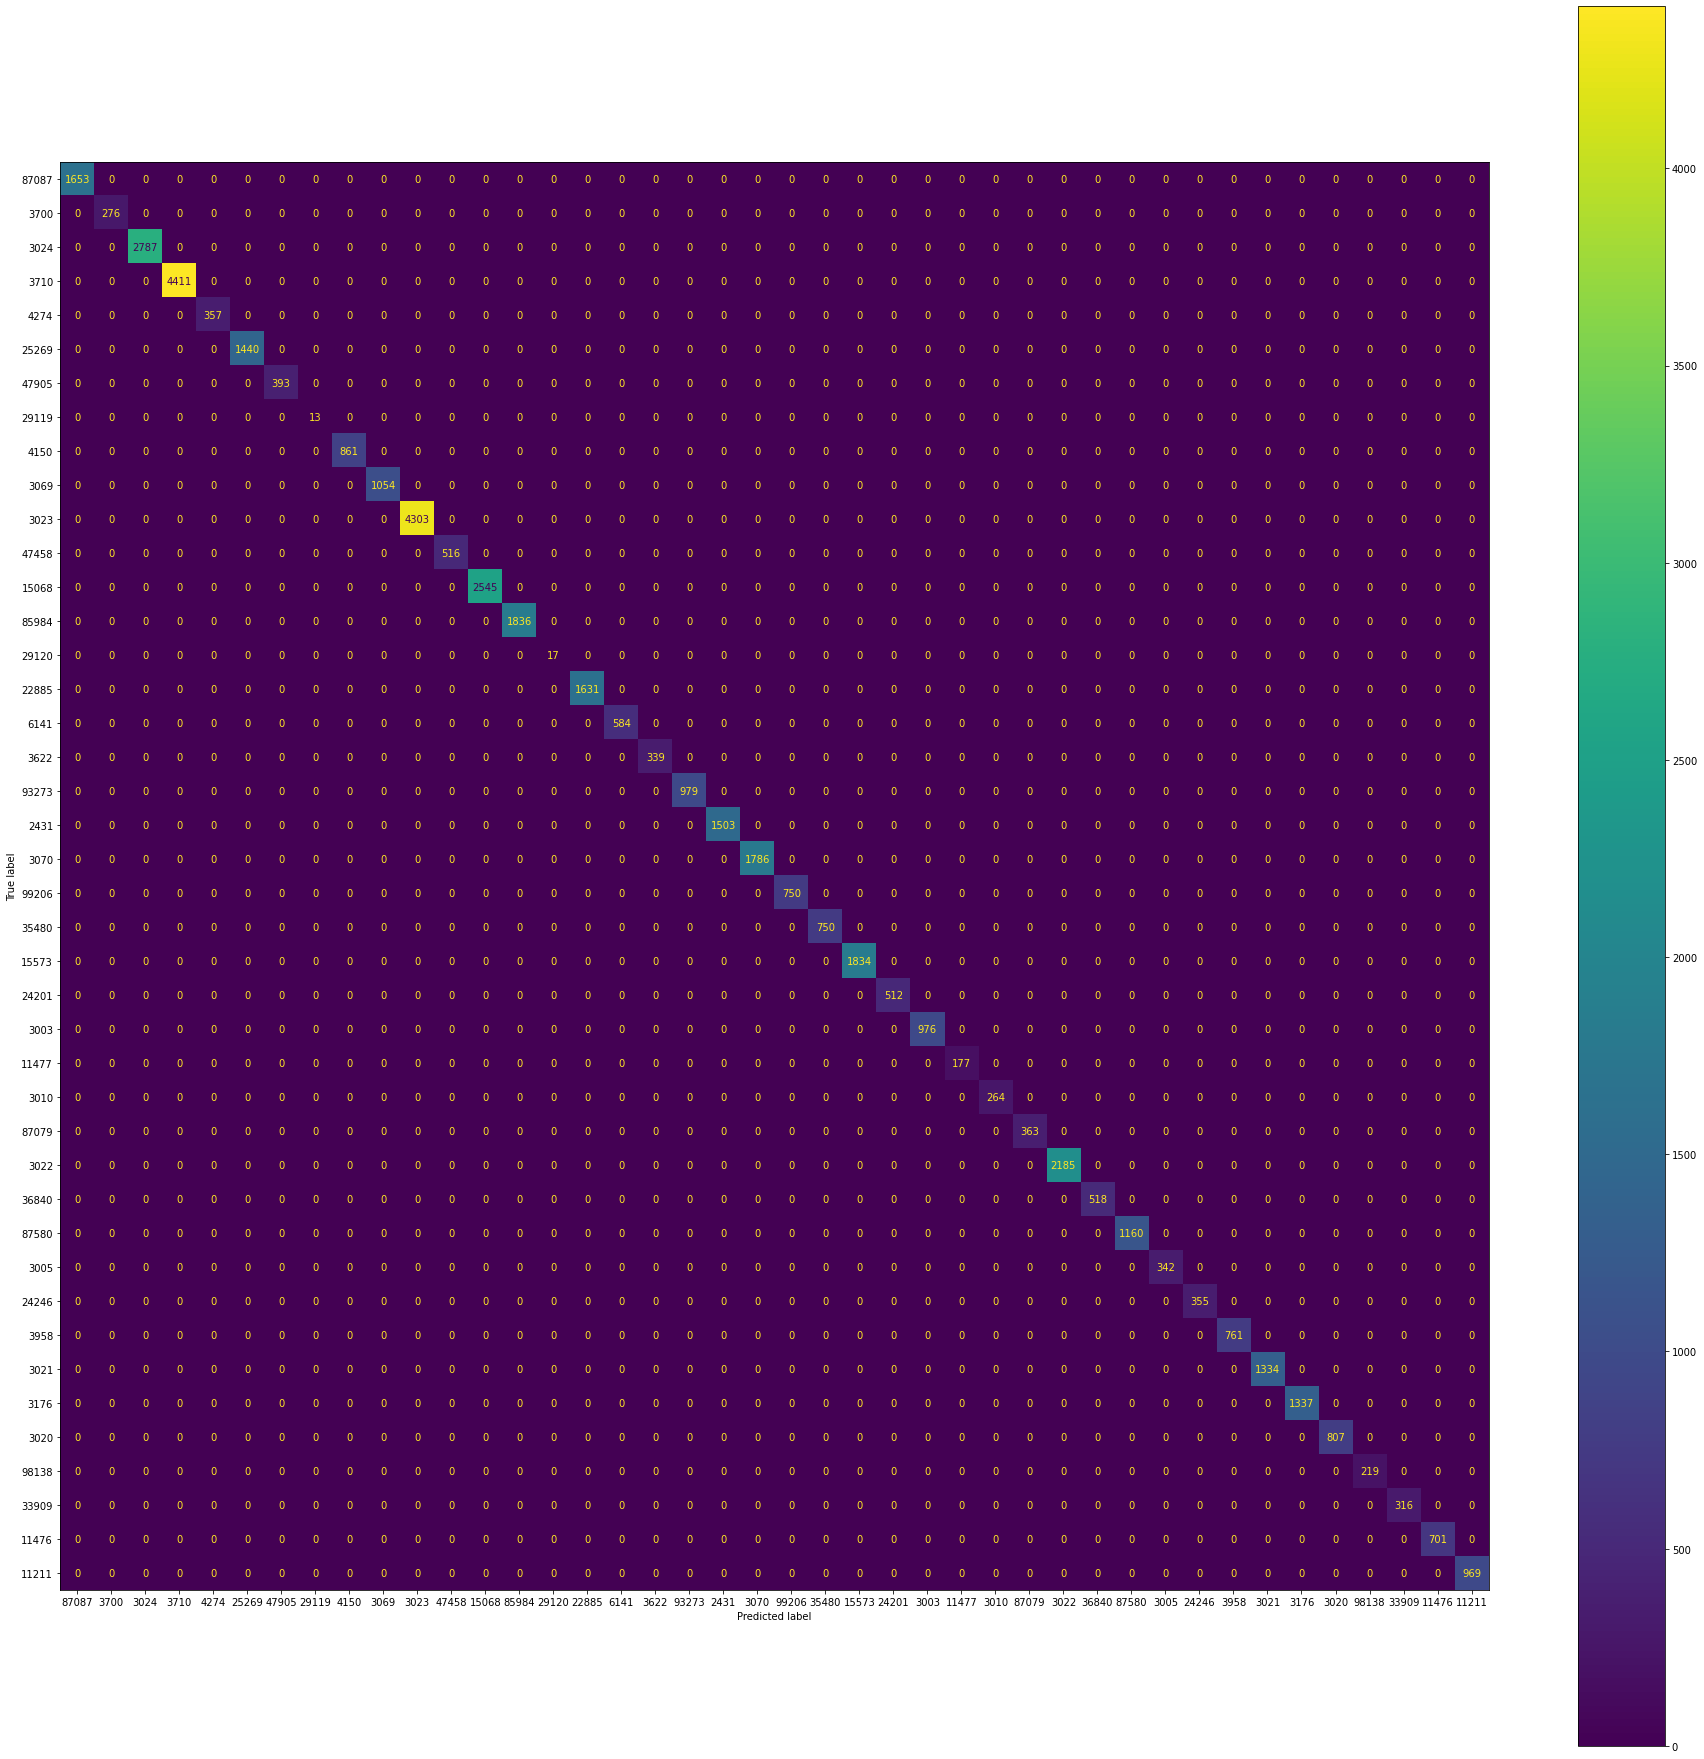

In [45]:
cm = results.confusion_matrix(classes=classes_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_all)

fig, ax = plt.subplots(figsize=(32,32))
disp.plot(ax=ax)

In [33]:
results.write_json('/tf/outputs.json')

In [ ]:
session = fo.launch_app(predictions_view, auto=False)
session.open_tab()